In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#FINAL GOAL: FIND POINT SOURCES
#what this code does: code to open the catalogs from sextractor and catalog fits file
#put them into arrays as seperate objects with the sorted out variables
#find matched objects in between the sextractor catalog and the fits catalog
#do some stuff with this (like finding the corrected pixel magnitude and finding the IC to detect point sources)

from __future__ import division
import astropy
from astropy.io import fits
import sys
import numpy as np
import math
from sklearn.linear_model import LinearRegression

#sextractor objects
class SextractorObj:
    def __init__(self,ra,dec,g_mag,u_mag,i_mag,z_mag,g_four,g_eight,u_four,u_eight,i_four,i_eight,z_four,z_eight):
        self.ra=ra
        self.dec=dec
        self.g_mag=g_mag
        self.u_mag=u_mag
        self.i_mag=i_mag
        self.z_mag=z_mag
        self.g_four=g_four
        self.g_eight=g_eight
        self.u_four=u_four
        self.u_eight=u_eight
        self.i_four=i_four
        self.i_eight=i_eight
        self.z_four=z_four
        self.z_eight=z_eight
    def __str__(self):
        return "SEXTRACTOR = ra: "+str(self.ra)+ "   dec: " + str(self.dec)+"   g-magnitude: "+str(self.g_mag)+"   u-magnitude: "+str(self.u_mag)+"   i-magnitude: "+str(self.i_mag)+"   z-magnitude: "+str(self.z_mag)
#corrected sextractor objects that have the corrected magnitudes
class CorrectedSextractorObj:    
    def __init__(self,ra,dec,g_mag,u_mag,i_mag,z_mag,g_corr_four,g_corr_eight,u_corr_four,u_corr_eight,i_corr_four,i_corr_eight,z_corr_four,z_corr_eight,inRange):
        self.ra=ra
        self.dec=dec
        self.g_mag=g_mag
        self.u_mag=u_mag
        self.i_mag=i_mag
        self.z_mag=z_mag
        self.g_corr_four=g_corr_four
        self.g_corr_eight=g_corr_eight
        self.u_corr_four=u_corr_four
        self.u_corr_eight=u_corr_eight
        self.i_corr_four=i_corr_four
        self.i_corr_eight=i_corr_eight
        self.z_corr_four=z_corr_four
        self.z_corr_eight=z_corr_eight
        self.inRange=inRange
    def __str__(self):
        return "Corrected SEXTRACTOR:" + "\n" + "g_corr_4: "+str(self.g_corr_four)+ "\n" + "g_corr_eight: " + str(self.g_corr_eight)+ "\n" +"u_corr_four: "+str(self.u_corr_four)+ "\n" + "u_corr_eight: "+str(self.u_corr_eight)+ "\n" +"i_corr_four: "+str(self.i_corr_four)+ "\n" +"i_corr_eight: "+str(self.i_corr_eight)+ "\n" +"z_corr_four: "+str(self.z_corr_four)+ "\n" +"z_corr_eight: "+str(self.z_corr_eight)
#fits objects
class FitsObj:
    def __init__(self,ra,dec,conc_index,gmag,umag,imag,zmag,insideRange):
        self.ra=ra
        self.dec=dec
        self.conc_index=conc_index
        self.gmag=gmag
        self.umag=umag
        self.imag=imag
        self.zmag=zmag
        self.insideRange=insideRange

    def __str__(self):
        return "FITS = ra: "+str(self.ra)+ "   dec: " + str(self.dec)+"   magnitude: " +str(self.mag)+"   IC: " +str(self.corr_index)
#the objects that match in the sextractor and fits objects arrays
class Match:
    def __init__(self,sex_object,fits_object,distance):
        self.sex_object=sex_object
        self.fits_object=fits_object
        self.distance=distance
    def __str__(self):
        return "MATCHED OBJECT = "+ str(self.distance) +"\n" + "FITS ra: "+str(self.fits_object.ra)+ "   dec: " + str(self.fits_object.dec)+"   magnitude: " +str(self.fits_object.mag)+"\n"+ "SEXTRACTOR ra: "+str(self.sex_object.ra)+ "   dec: " + str(self.sex_object.dec)+"   magnitude: " +str(self.sex_object.u_mag)        
        
    
    
    
#finding the distance between the sextractor and fits catalog to find the perfect match
def distance (s_ra,f_ra,s_dec,f_dec):
    rad_f_dec=f_dec*(math.pi/180)
    length=math.sqrt(((s_ra-f_ra)*(math.cos(rad_f_dec)))**2+(s_dec-f_dec)**2)
    return length

#does the linear regression
def correct (mag_4,mag_8,aper_cor_mag):
    x = np.array(mag_4).reshape(-1,1)
    y = aper_cor_mag    
    model_4 = LinearRegression().fit(x, y)
    a = np.array(mag_8).reshape(-1,1)
    b = aper_cor_mag
    model_8 = LinearRegression().fit(a, b)
    return model_4,model_8

#assign the linear regression values to a dictionary
def linear_regression(sex_object,fits_object,point_source_array):
    ufour=[]
    ueight=[]
    gfour=[]
    geight=[]
    ifour=[]
    ieight=[]
    zfour=[]
    zeight=[]
    aper_cor_umag=[]
    aper_cor_gmag=[]
    aper_cor_imag=[]
    aper_cor_zmag=[]
    for obj in point_source_array:
        ufour.append(obj.sex_object.u_four)
        ueight.append(obj.sex_object.u_eight)
        gfour.append(obj.sex_object.g_four)
        geight.append(obj.sex_object.g_eight)
        ifour.append(obj.sex_object.i_four)
        ieight.append(obj.sex_object.i_eight)
        zfour.append(obj.sex_object.z_four)
        zeight.append(obj.sex_object.z_eight)
        aper_cor_umag.append(obj.fits_object.umag)
        aper_cor_gmag.append(obj.fits_object.gmag)
        aper_cor_imag.append(obj.fits_object.imag)
        aper_cor_zmag.append(obj.fits_object.zmag)  
    models=dict()
    models["u4"],models["u8"]=correct(ufour,ueight,aper_cor_umag)
    models["g4"],models["g8"]=correct(gfour,geight,aper_cor_gmag)
    models["i4"],models["i8"]=correct(ifour,ieight,aper_cor_imag)
    models["z4"],models["z8"]=correct(zfour,zeight,aper_cor_zmag)
    return models
sex_obj=[]
corr_sex_obj=[]
fits_obj=[]
match_obj=[]
def open_catalog(catalog_file_name,g_sextractor_catalog):
    #getting the necessary data from the fits catalog
    x_sex,y_sex,ra,dec,umag,gmag,rmag,imag,zmag,umagerr,gmagerr,rmagerr,imagerr,zmagerr,ic,p_gc=([] for i in range(16))
    arr=[x_sex,y_sex,ra,dec,umag,gmag,rmag,imag,zmag,umagerr,gmagerr,rmagerr,imagerr,zmagerr,ic,p_gc]
    hdul=fits.open(catalog_file_name)
    data=hdul[1].data
    arr_indexes=[0,1,2,3,5,6,7,8,9,11,12,13,14,15,17,28]
    index=0
    for x in range(len(data)):
        sep_data=data[x]
        for y in arr_indexes:
            current_arr=arr[index]
            current_arr.append(sep_data[y])
            index=index+1
        index=0
    #opening the sextractor catalog and getting all its contents   
    u_sextractor_catalog=g_sextractor_catalog[0:8]+"u.cat"
    i_sextractor_catalog=g_sextractor_catalog[0:8]+"i.cat"
    z_sextractor_catalog=g_sextractor_catalog[0:8]+"z.cat"
    g_nmb,g_x_image,g_y_image,g_alpha,g_delta,g_a_world,g_erra_world,g_b_world,g_errb_world,g_theta_pa,g_errtheta_pa,g_elongation,g_ellip,g_mag_auto,g_magerr_auto,g_mag_best,g_magerr_best,g_mag_iso,g_magerr_iso,g_mag_isocor,g_magerr_isocor,g_mag_petro,g_magerr_petro,g_mag_aper,g_four,u_26,u_27,u_28,g_eight,u_30,u_31,g_magerr_aper,u_33,u_34,u_35,u_36,u_37,u_38,u_39,g_flux_rad,g_kron_rad,g_petro_rad,g_mu_max,g_background,g_isoarea_image,g_fwhm_image,g_flags,g_class_star=np.loadtxt(g_sextractor_catalog,unpack=True)
    u_nmb,u_x_image,u_y_image,u_alpha,u_delta,u_a_world,u_erra_world,u_b_world,u_errb_world,u_theta_pa,u_errtheta_pa,u_elongation,u_ellip,u_mag_auto,u_magerr_auto,u_mag_best,u_magerr_best,u_mag_iso,u_magerr_iso,u_mag_isocor,u_magerr_isocor,u_mag_petro,u_magerr_petro,u_mag_aper,u_four,u1_26,u1_27,u1_28,u_eight,u1_30,u1_31,u_magerr_aper,u1_33,u1_34,u1_35,u1_36,u1_37,u1_38,u1_39,u_flux_rad,u_kron_rad,u_petro_rad,u_mu_max,u_background,u_isoarea_image,u_fwhm_image,u_flags,u_class_star=np.loadtxt(u_sextractor_catalog,unpack=True)
    i_nmb,i_x_image,i_y_image,i_alpha,i_delta,i_a_world,i_erra_world,i_b_world,i_errb_world,i_theta_pa,i_errtheta_pa,i_elongation,i_ellip,i_mag_auto,i_magerr_auto,i_mag_best,i_magerr_best,i_mag_iso,i_magerr_iso,i_mag_isocor,i_magerr_isocor,i_mag_petro,i_magerr_petro,i_mag_aper,i_four,u2_26,u2_27,u2_28,i_eight,u2_30,u2_31,i_magerr_aper,u2_33,u2_34,u2_35,u2_36,u2_37,u2_38,u2_39,i_flux_rad,i_kron_rad,i_petro_rad,i_mu_max,i_background,i_isoarea_image,i_fwhm_image,i_flags,i_class_star=np.loadtxt(i_sextractor_catalog,unpack=True)
    z_nmb,z_x_image,z_y_image,z_alpha,z_delta,z_a_world,z_erra_world,z_b_world,z_errb_world,z_theta_pa,z_errtheta_pa,z_elongation,z_ellip,z_mag_auto,z_magerr_auto,z_mag_best,z_magerr_best,z_mag_iso,z_magerr_iso,z_mag_isocor,z_magerr_isocor,z_mag_petro,z_magerr_petro,z_mag_aper,z_four,u3_26,u3_27,u3_28,z_eight,u3_30,u3_31,z_magerr_aper,u3_33,u3_34,u3_35,u3_36,u3_37,u3_38,u3_39,z_flux_rad,z_kron_rad,z_petro_rad,z_mu_max,z_background,z_isoarea_image,z_fwhm_image,z_flags,z_class_star=np.loadtxt(z_sextractor_catalog,unpack=True)
    
    #adding FITS objects into the fits array
    for fits_index in range(len(x_sex)):
        fits_obj.append(FitsObj(ra[fits_index],dec[fits_index],ic[fits_index],gmag[fits_index],umag[fits_index],imag[fits_index],zmag[fits_index],False))
                
    #adding Sextractor objects into the sextractor objects array 
    for sex_index in range(len(g_x_image)):
        sex_obj.append(SextractorObj(g_alpha[sex_index],g_delta[sex_index],g_mag_aper[sex_index],u_mag_aper[sex_index],i_mag_aper[sex_index],z_mag_aper[sex_index],g_four[sex_index],g_eight[sex_index],u_four[sex_index],u_eight[sex_index],i_four[sex_index],i_eight[sex_index],z_four[sex_index],z_eight[sex_index]))
    #finding the matched objects between the sextractor catalog and the fits catalog
    for f in fits_obj:
        for s in sex_obj:
            current_distance=distance(s.ra,f.ra,s.dec,f.dec)
            if(current_distance<=(1/3600)):
                match_obj.append(Match(s,f,current_distance))
    #finding point sources from the matched fits object
    point_source=[]
    for obj in match_obj:
        if obj.fits_object.conc_index<0.1:
            point_source.append(obj)          
            
    #calling linear regression method 
    models=linear_regression(sex_obj,fits_obj,point_source)
    for i in range(len(sex_obj)):
        u_corr_four=((models["u4"].coef_)*sex_obj[i].u_four)+(models["u4"].intercept_)
        u_corr_eight=((models["u8"].coef_)*sex_obj[i].u_eight)+(models["u8"].intercept_)
        g_corr_four=((models["g4"].coef_)*sex_obj[i].g_four)+(models["g4"].intercept_)
        g_corr_eight=((models["g8"].coef_)*sex_obj[i].g_eight)+(models["g8"].intercept_)
        i_corr_four=((models["i4"].coef_)*sex_obj[i].i_four)+(models["i4"].intercept_)
        i_corr_eight=((models["i8"].coef_)*sex_obj[i].i_eight)+(models["i8"].intercept_)
        z_corr_four=((models["z4"].coef_)*sex_obj[i].z_four)+(models["z4"].intercept_)
        z_corr_eight=((models["z8"].coef_)*sex_obj[i].z_eight)+(models["z8"].intercept_)
        corr_sex_obj.append(CorrectedSextractorObj(g_alpha[i],g_delta[i],g_mag_aper[i],u_mag_aper[i],i_mag_aper[i],z_mag_aper[i],g_corr_four,g_corr_eight,u_corr_four,u_corr_eight,i_corr_four,i_corr_eight,z_corr_four,z_corr_eight,False))  
    
    #finding the concentration index (IC) using iband and also checking the color restrictions
    pass_difference=0
    pass_xy=0
    pass_equations=0
    for x in range(len(corr_sex_obj)):
        difference=corr_sex_obj[x].i_corr_four-corr_sex_obj[x].i_corr_eight
        if difference>=-0.1 and difference<=0.15:
            pass_difference=pass_difference+1
            x_coord=corr_sex_obj[x].u_corr_four-corr_sex_obj[x].g_corr_four
            y_coord=corr_sex_obj[x].g_corr_four-corr_sex_obj[x].i_corr_four
            if (x_coord>0.8 and x_coord<1.9) and (y_coord<1.7 and y_coord>1):
                pass_xy=pass_xy+1
                if y_coord<(0.56*x_coord)+0.85 and  y_coord>(0.6*x_coord)+0.35:
                    corr_sex_obj[x].inRange=True
                    pass_equations=pass_equations+1
    f_pass_difference=0
    f_pass_xy=0
    f_pass_equations=0
    for x in range(len(fits_obj)):
        difference=fits_obj[x].conc_index
        if difference>=-0.1 and difference<=0.15:
            f_pass_difference=f_pass_difference+1
            #just use four pixel numbers for now but make sure to check what youkyung says
            x_coord=fits_obj[x].umag-fits_obj[x].gmag
            y_coord=fits_obj[x].gmag-fits_obj[x].imag
            if (x_coord>0.8 and x_coord<1.9) and (y_coord<1.7 and y_coord>1):
                f_pass_xy=f_pass_xy+1
                if y_coord<(0.56*x_coord)+0.85 and  y_coord>(0.6*x_coord)+0.35:
                    fits_obj[x].insideRange=True
                    f_pass_equations=f_pass_equations+1
    #print("passed difference, passed xy, passed equations, length of sex_obj")
    #print(pass_difference)
    #print(pass_xy)
    #print(pass_equations)
 

In [3]:
open_catalog("VCC1407_NGVS2308_cat.fits","VCC1407_g.cat")

passed difference, passed xy, passed equations, length of sex_obj
379
16
10


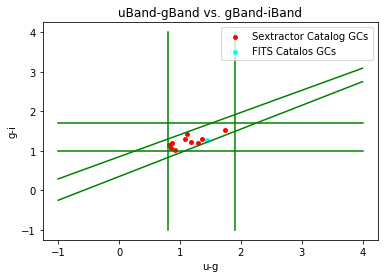

In [4]:
#u-g magnitude
ug_mag=[]
#g-i magnitude
gi_mag=[]
ug_pt_source=[]
gi_pt_source=[]
fits_ug_source=[]
fits_gi_source=[]
for obj in corr_sex_obj:
    ug_mag.append(obj.u_corr_four-obj.g_corr_four)
    gi_mag.append(obj.g_corr_four-obj.i_corr_four)
    if obj.inRange==True:
        ug_pt_source.append(obj.u_corr_four-obj.g_corr_four)
        gi_pt_source.append(obj.g_corr_four-obj.i_corr_four)
for obj in fits_obj:
    if obj.insideRange==True:
        fits_ug_source.append(obj.umag-obj.gmag)
        fits_gi_source.append(obj.gmag-obj.imag)
#plt.scatter(ug_mag, gi_mag,s = 15, c = 'blue')
#print(len(ug_pt_source))
#print(len(fits_gi_source))
#print(len(fits_gi_source))
#print(len(fits_ug_source))
plt.scatter(ug_pt_source, gi_pt_source,s = 15, c = 'red',label = 'Sextractor Catalog GCs')
plt.scatter(fits_ug_source, fits_gi_source,s = 15, c = 'cyan',label = 'FITS Catalos GCs')
x=np.linspace(-1,4,100)
y=np.linspace(-1,4,100)
plt.plot(x,0.6*x+0.35,'-g')
plt.plot(x,0.56*x+0.85,'-g')
plt.plot(x,0*x+1.7,'-g')
plt.plot(x,0*x+1,'-g')
plt.plot(0*y+0.8,y,'-g')
plt.plot(0*y+1.9,y,'-g')
plt.ylabel("g-i")
plt.xlabel("u-g")
plt.title("uBand-gBand vs. gBand-iBand")
plt.legend()
plt.show()

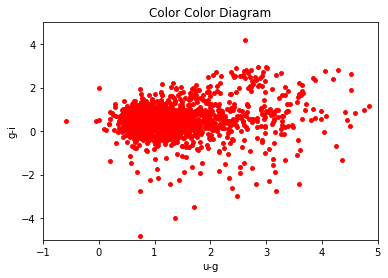

In [5]:
#u-g magnitude
ug_mag=[]
#g-i magnitude
gi_mag=[]
for obj in corr_sex_obj:
    ug_mag.append(obj.u_corr_four-obj.g_corr_four)
    gi_mag.append(obj.g_corr_four-obj.i_corr_four)
plt.scatter(ug_mag, gi_mag,s = 15, c = 'red')
x=np.linspace(-1,4,100)
y=np.linspace(-1,4,100) 
plt.xlim(-1, 5)
plt.ylim(-5, 5)     
plt.ylabel("g-i")
plt.xlabel("u-g")
plt.title("Color Color Diagram")
plt.show()

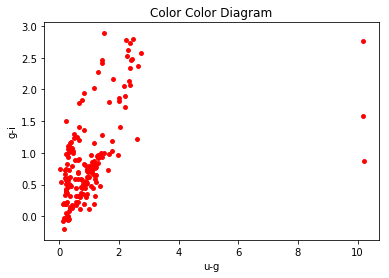

In [6]:
#u-g magnitude
ug_mag=[]
#g-i magnitude
gi_mag=[]
for obj in fits_obj:
    ug_mag.append(obj.umag-obj.gmag)
    gi_mag.append(obj.gmag-obj.imag)
plt.scatter(ug_mag, gi_mag,s = 15, c = 'red')
x=np.linspace(-1,4,100)
y=np.linspace(-1,4,100) 
#plt.xlim(-1, 5)
#plt.ylim(-5, 5)     
plt.ylabel("g-i")
plt.xlabel("u-g")
plt.title("Color Color Diagram")
plt.show()